In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def load_iris():
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
    cols = ['sepal_length','sepal_width','petal_length','petal_width','species']
    df = pd.read_csv(url, names=cols)
    df = df.dropna()
    return df

In [3]:
def encode_labels(species):
    uniques = list(set(species))
    mapping = {s:i for i,s in enumerate(uniques)}
    return np.array([mapping[s] for s in species]), mapping

In [4]:
def standardize(X):
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    return (X - mean) / std

In [5]:
def train_test_split(X, y, train_ratio=0.8):
    n = len(X)
    idx = np.arange(n)
    np.random.shuffle(idx)
    train_end = int(train_ratio*n)
    X_train, X_test = X[idx[:train_end]], X[idx[train_end:]]
    y_train, y_test = y[idx[:train_end]], y[idx[train_end:]]
    return X_train, X_test, y_train, y_test

Classification Report
Confusion Matrix:
 [[ 7  0  0]
 [ 0 11  1]
 [ 0  1 10]]
Macro F1: 0.9419
Micro F1: 0.9333
Weighted F1: 0.9333


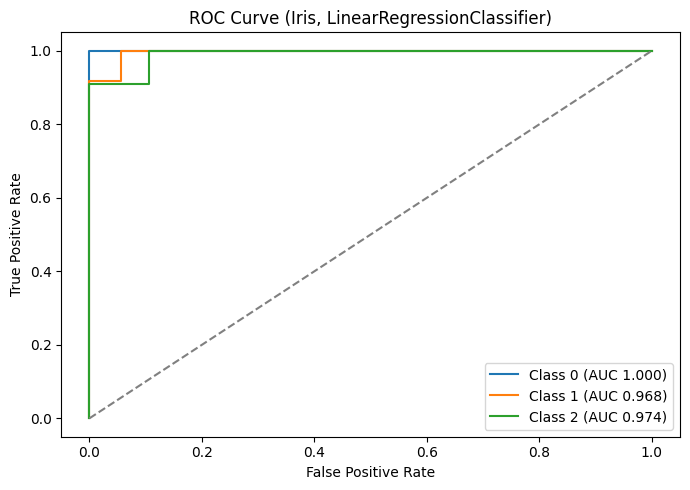

AUCs for each class: [1.0, 0.9675925925925926, 0.9736842105263158]
Mean AUC: 0.9804256010396362
Regression Metrics (Predict petal_length):
MAE: 0.2382619144419712
MSE: 0.09849336443699261
R^2: 0.968150119089107


In [6]:
def linear_regression_normal_eq(X, y):
    X_ = np.column_stack([np.ones(X.shape[0]), X])
    w = np.linalg.inv(X_.T @ X_) @ X_.T @ y
    return w

def predict_linear(X, w):
    X_ = np.column_stack([np.ones(X.shape[0]), X])
    return X_ @ w

def confusion_matrix(y_true, y_pred, n_classes):
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for t,p in zip(y_true, y_pred):
        cm[t,p] += 1
    return cm

def micro_f1(cm):
    tp = np.diag(cm).sum()
    fp = cm.sum(axis=0) - np.diag(cm)
    fn = cm.sum(axis=1) - np.diag(cm)
    precision = tp / (tp + fp.sum()) if (tp + fp.sum()) > 0 else 0
    recall = tp / (tp + fn.sum()) if (tp + fn.sum()) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return f1

def macro_f1(cm):
    n_classes = len(cm)
    f1s = []
    for i in range(n_classes):
        tp = cm[i,i]
        fp = cm[:,i].sum() - tp
        fn = cm[i,:].sum() - tp
        precision = tp / (tp + fp) if (tp+fp) > 0 else 0
        recall = tp / (tp + fn) if (tp+fn) > 0 else 0
        f1 = 2 * precision * recall / (precision+recall) if (precision+recall) > 0 else 0
        f1s.append(f1)
    return np.mean(f1s)

def weighted_f1(cm):
    counts = cm.sum(axis=1)
    f1s = []
    for i in range(len(cm)):
        tp = cm[i,i]
        fp = cm[:,i].sum() - tp
        fn = cm[i,:].sum() - tp
        precision = tp / (tp + fp) if (tp+fp) > 0 else 0
        recall = tp / (tp + fn) if (tp+fn) > 0 else 0
        f1 = 2 * precision * recall / (precision+recall) if (precision+recall) > 0 else 0
        f1s.append(f1)
    return np.average(f1s, weights=counts)

# (From Assignment 5)
class LinearRegressionClassifier:
    def __init__(self, lr=0.01, max_iter=1000, tol=1e-6):
        self.lr = lr
        self.max_iter = max_iter
        self.tol = tol
    def _add_bias(self, X):
        return np.column_stack([np.ones(X.shape[0]), X])
    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1/(1+np.exp(-z))
    def fit(self, X, y):
        Xb = self._add_bias(X)
        self.n_classes = len(np.unique(y))
        n_feat = Xb.shape[1]
        one_hot = np.eye(self.n_classes)[y]
        self.w = np.random.normal(0,0.01,(n_feat, self.n_classes))
        for _ in range(self.max_iter):
            z = Xb @ self.w
            p = self._sigmoid(z)
            cost = ((p-one_hot)**2).mean()
            grad = Xb.T @ (p-one_hot) / len(X)
            self.w -= self.lr * grad
            if (np.abs(grad).max() < self.tol):
                break
    def predict_proba(self, X):
        Xb = self._add_bias(X)
        z = Xb @ self.w
        p = self._sigmoid(z)
        return p / (p.sum(axis=1, keepdims=True) + 1e-8)
    def predict(self, X):
        p = self.predict_proba(X)
        return np.argmax(p, axis=1)

# ROC/AUC IMPLEMENTATION
def roc_curve_bin(y_true, y_scores, pos_label=1):
    thresholds = np.linspace(0,1,101)
    tpr = []
    fpr = []
    for thresh in thresholds:
        y_pred = (y_scores >= thresh).astype(int)
        tp = ((y_true==pos_label) & (y_pred==pos_label)).sum()
        fn = ((y_true==pos_label) & (y_pred!=pos_label)).sum()
        fp = ((y_true!=pos_label) & (y_pred==pos_label)).sum()
        tn = ((y_true!=pos_label) & (y_pred!=pos_label)).sum()
        tpr.append(tp/(tp+fn) if (tp+fn)>0 else 0)
        fpr.append(fp/(fp+tn) if (fp+tn)>0 else 0)
    return np.array(fpr), np.array(tpr)

def auc_score(fpr, tpr):
    sorted_idx = np.argsort(fpr)
    fpr, tpr = fpr[sorted_idx], tpr[sorted_idx]
    auc = np.trapz(tpr, fpr)
    return auc

def mean_abs_error(y_true, y_pred):
    return np.mean(np.abs(y_true-y_pred))
def mean_sq_error(y_true, y_pred):
    return np.mean((y_true-y_pred)**2)
def r2_score(y_true, y_pred):
    ssr = ((y_true-y_pred)**2).sum()
    sst = ((y_true-y_true.mean())**2).sum()
    return 1 - ssr/sst

np.random.seed(42)
df = load_iris()
X = df[['sepal_length','sepal_width','petal_length','petal_width']].values
y, mapping = encode_labels(df['species'].values)
X = standardize(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, 0.8)
n_classes = len(set(y))

model = LinearRegressionClassifier(lr=0.1, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
probas = model.predict_proba(X_test)

cm = confusion_matrix(y_test, y_pred, n_classes)
micro = micro_f1(cm)
macro = macro_f1(cm)
weighted = weighted_f1(cm)

print("Classification Report")
print("Confusion Matrix:\n",cm)
print("Macro F1: %.4f"%macro)
print("Micro F1: %.4f"%micro)
print("Weighted F1: %.4f"%weighted)

plt.figure(figsize=(7,5))
aucs = []
for c in range(n_classes):
    y_true = (y_test == c).astype(int)
    y_score = probas[:,c]
    fpr, tpr = roc_curve_bin(y_true, y_score, pos_label=1)
    auc = auc_score(fpr, tpr)
    aucs.append(auc)
    plt.plot(fpr, tpr, label='Class %d (AUC %.3f)'%(c,auc))
plt.plot([0,1],[0,1],'--',color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Iris, LinearRegressionClassifier)")
plt.legend()
plt.tight_layout()
plt.show()

print("AUCs for each class:", aucs)
print("Mean AUC:", np.mean(aucs))

y_reg = df['petal_length'].values
X_reg = df[['sepal_length','sepal_width','petal_width']].values
X_reg = standardize(X_reg)

w = linear_regression_normal_eq(X_reg, y_reg)
y_reg_pred = predict_linear(X_reg, w)

mae = mean_abs_error(y_reg, y_reg_pred)
mse = mean_sq_error(y_reg, y_reg_pred)
r2 = r2_score(y_reg, y_reg_pred)

print("Regression Metrics (Predict petal_length):")
print("MAE:", mae)
print("MSE:", mse)
print("R^2:", r2)
